# Train data

In [1]:
import tensorflow as tf
from src.dataPipeline.train_val import create_split
from config.data_pipeline_config import get_train_val_pipeline_config

cfg = get_train_val_pipeline_config()

options = tf.data.Options()
options.threading.private_threadpool_size = 48

dataset_path = '/home/anirudhan/project/fusion/data/memmaps/train_images10.tfrecords.gz'
# dataset = tf.data.TFRecordDataset(dataset_path, compression_type="GZIP").with_options(options)
# dataset = dataset.map(_parse_function).map(_reshape).map(lambda x: normalize_image(x, 'train')).map(_resize)
train_dataset, no_train_samples = create_split(dataset_path, 16, 'train', shuffle_buffer_size=5_00, cfg=cfg)
train_dataset = train_dataset.as_numpy_iterator()

2024-03-27 06:29:37.171547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 06:29:37.664503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/anirudhan/miniconda3/envs/fusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-27 06:29:38.872615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docume

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [2]:
print("No of train samples:",no_train_samples)

No of train samples: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


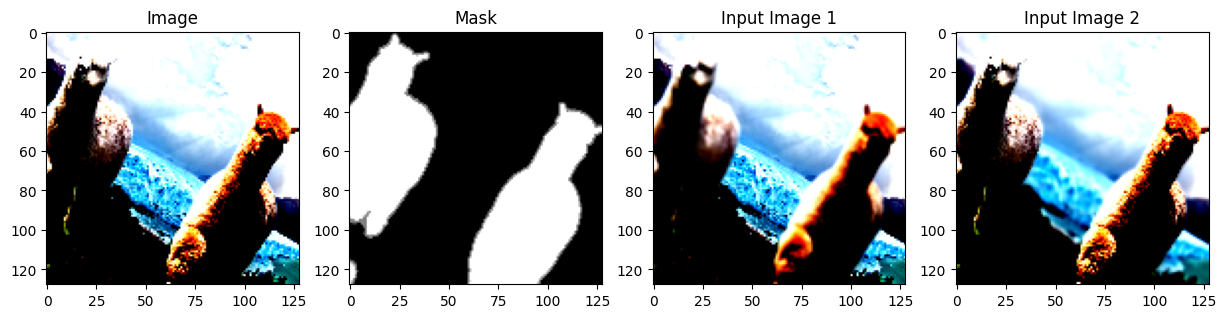

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


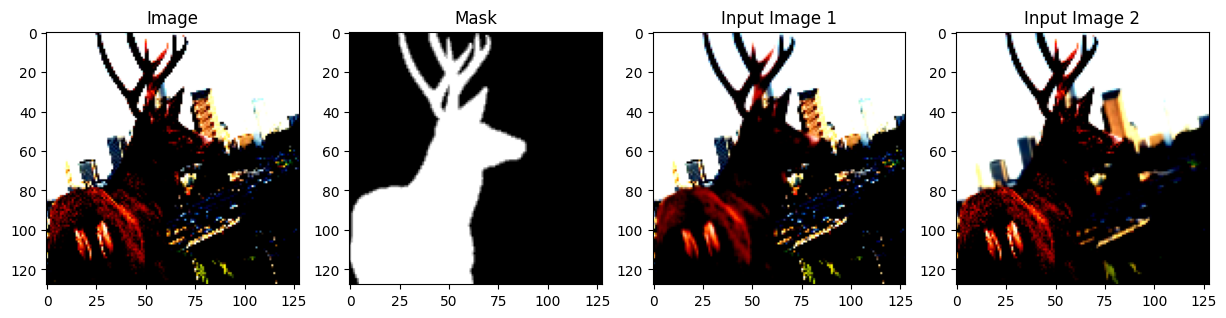

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


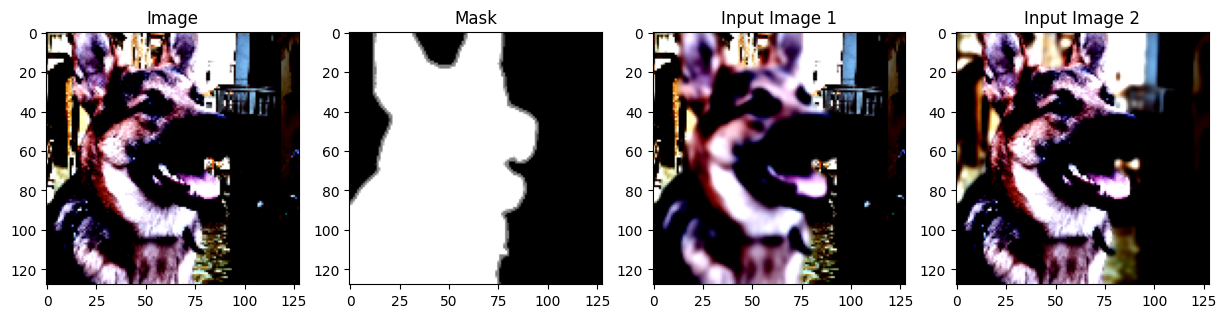

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


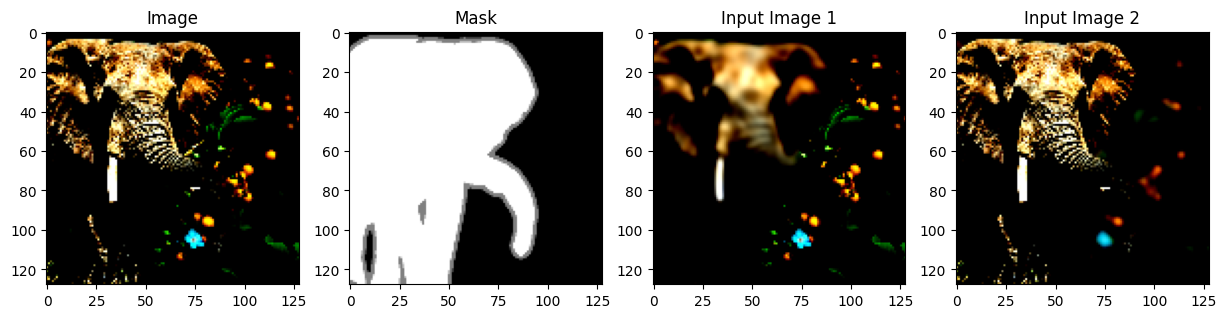

In [3]:
import tensorflow as tf
import numpy as np
import io
from PIL import Image
import matplotlib.pyplot as plt

for i, parsed_record in enumerate(train_dataset):
    # Decode all images
    # img = tf.reshape(tf.io.decode_raw(parsed_record['image'], tf.uint8), (512, 512, 3)).numpy()
    # mask = tf.reshape(tf.io.decode_raw(parsed_record['mask'], tf.uint8), (512, 512, 3)).numpy()  # Assuming similar shape
    # input_img_1 = tf.reshape(tf.io.decode_raw(parsed_record['input_img_1'], tf.uint8), (512, 512, 3)).numpy()
    # input_img_2 = tf.reshape(tf.io.decode_raw(parsed_record['input_img_2'], tf.uint8), (512, 512, 3)).numpy()
    img = parsed_record['image']
    mask = parsed_record['mask']
    input_img_1 = parsed_record['input_img_1']
    input_img_2 = parsed_record['input_img_2']
    # Create subplots with labels
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed
    axes[0].imshow(img[0])
    axes[0].set_title("Image")
    axes[1].imshow(mask[0])
    axes[1].set_title("Mask")
    axes[2].imshow(input_img_1[0])
    axes[2].set_title("Input Image 1")
    axes[3].imshow(input_img_2[0])
    axes[3].set_title("Input Image 2")
    plt.show()
    if i == 3 : break


# train

In [7]:
import jax
import einops
import jaxwt as jwt
from functools import partial
import flax.linen as nn
from train.train import *
import jax.numpy as jnp

model_dtype = jax.numpy.bfloat16
Conv3x3 = partial(nn.Conv, kernel_size=(3,3), padding='SAME')
Conv7x7 = partial(nn.Conv, kernel_size=(7,7), padding='SAME')
rearange_width_first = lambda x: einops.rearrange(x, "n h w c -> n c h w")
rearange_height_first = lambda x: einops.rearrange(x, "n c h w -> n c w h")
Conv1x1 = partial(nn.Conv, padding='SAME')

class ConvBlock(nn.Module):
    dimention : int
    dtype: Any = jnp.float32
    @nn.compact
    def __call__(self, image, train=False):
        feature = Conv3x3(self.dimention, param_dtype=self.dtype)(image)
        feature = nn.activation.gelu(feature)
        feature = Conv3x3(128, param_dtype=self.dtype)(image)
        feature = nn.activation.gelu(feature)
        feature = Conv3x3(self.dimention, param_dtype=self.dtype)(image)
        feature = nn.activation.gelu(feature)
        feature = nn.BatchNorm(use_running_average = not train, param_dtype=self.dtype)(feature)
        return feature

class FusionModel(nn.Module):
    dtype: Any = jnp.float32
    @nn.compact
    def __call__(self, image1, image2, train=False):
        feature1 = ConvBlock(3, self.dtype)(image1, train)
        feature2 = ConvBlock(3, self.dtype)(image2, train)
        return feature1 + feature2

In [8]:
from train.train import *
from flax.training import common_utils
from clu import metric_writers
from absl import logging

logging.set_verbosity(logging.INFO)

workdir = '/home/anirudhan/project/fusion/results'
# checkpoint_manager = create_checkpoints_manager(config, '/content')
config = get_default_configs()
config.image_size = 128

writer = metric_writers.create_default_writer(
    logdir=config.log_dir
)

rng = jax.random.PRNGKey(0)

writer = metric_writers.create_default_writer(
      logdir=workdir, just_logging=jax.process_index() != 0
  )

if config.batch_size % jax.device_count() > 0:
    raise ValueError('Batch size must be divisible by the number of devices')
local_batch_size = config.batch_size // jax.process_count()

steps_per_epoch = (
      no_train_samples // config.batch_size
  )

if config.no_train_steps <= 0:
    num_steps = int(steps_per_epoch * config.batch_size)
else :
    num_steps = config.no_train_steps
    
steps_per_checkpoint = steps_per_epoch * 10
base_learning_rate = config.learning_rate * config.batch_size / 256.0

model = FusionModel()

learning_rate_fn = create_learning_rate_fn(
    config, base_learning_rate, steps_per_epoch
)
state = create_train_state(rng, config, model, learning_rate_fn)

step_offset = int(state.step)
#state = jax_utils.replicate(state) this should br used only if we are using multiple devices
train_step = functools.partial(train_step, learning_rate_fn=learning_rate_fn)

In [4]:
rng = rng = jax.random.PRNGKey(0)
model = FusionModel(dtype=jnp.bfloat16)
params = model.init(rng, jnp.ones((1, 128, 128, 3), dtype=jnp.bfloat16), jnp.ones((1, 128, 128, 3), dtype=jnp.bfloat16), train=True)

In [9]:
print(jax.tree_map(lambda x: x.dtype, state.params))

{'ConvBlock_0': {'BatchNorm_0': {'bias': dtype('float32'), 'scale': dtype('float32')}, 'Conv_0': {'bias': dtype('float32'), 'kernel': dtype('float32')}, 'Conv_1': {'bias': dtype('float32'), 'kernel': dtype('float32')}, 'Conv_2': {'bias': dtype('float32'), 'kernel': dtype('float32')}}, 'ConvBlock_1': {'BatchNorm_0': {'bias': dtype('float32'), 'scale': dtype('float32')}, 'Conv_0': {'bias': dtype('float32'), 'kernel': dtype('float32')}, 'Conv_1': {'bias': dtype('float32'), 'kernel': dtype('float32')}, 'Conv_2': {'bias': dtype('float32'), 'kernel': dtype('float32')}}}


In [7]:
jax.process_index()

0

In [10]:
train_metrics = []

# if jax.process_index() == 0:
#     hooks += [periodic_actions.Profile(num_profile_steps=5, logdir=workdir)]

train_metrics_last_t = time.time()
train_iter = create_input_iter(train_dataset)

logging.info('Initial compilation, this might take some minutes...')
for step, batch in zip(range(step_offset, num_steps), train_iter):
    state, metrics = train_step(state, batch)
    logging.info(f'Step {step}: {metrics}')
    writer.write_scalars(step, metrics)
    
    if step == step_offset:
        logging.info('Initial compilation completed.')

    if config.get('log_every_steps'):
        train_metrics.append(metrics)
        # if (step + 1) % config.log_every_steps == 0:
        #     summary = {
        #         f'train_{k}': v
        #         for k, v in jax.tree_util.tree_map(lambda x: x.mean(), train_metrics)#.items()
        #     }
        #     summary['steps_per_second'] = config.log_every_steps / (time.time() - train_metrics_last_t)
        #     writer.write_scalars(step + 1, summary)
        #     train_metrics = []
        #     train_metrics_last_t = time.time()

    if (step + 1) % steps_per_epoch == 0:
        epoch = step // steps_per_epoch
        eval_metrics = []

        # sync batch statistics across replicas
        # state = sync_batch_stats(state)

    if step == no_train_samples // config.batch_size * config.epochs - 1:
        break


INFO:absl:Initial compilation, this might take some minutes...
INFO:absl:Step 0: {'loss': Array(2.0885952, dtype=float32), 'lr': Array(0., dtype=float32, weak_type=True)}
INFO:absl:[0] loss=2.088595151901245, lr=0.0
INFO:absl:Initial compilation completed.
INFO:absl:Step 1: {'loss': Array(2.1783056, dtype=float32), 'lr': Array(8.0645084e-05, dtype=float32, weak_type=True)}
INFO:absl:[1] loss=2.1783056259155273, lr=8.064508438110352e-05
INFO:absl:Step 2: {'loss': Array(2.0977879, dtype=float32), 'lr': Array(0.00016129, dtype=float32, weak_type=True)}
INFO:absl:[2] loss=2.097787857055664, lr=0.00016129016876220703
INFO:absl:Step 3: {'loss': Array(2.0308793, dtype=float32), 'lr': Array(0.00024194, dtype=float32, weak_type=True)}
INFO:absl:[3] loss=2.030879259109497, lr=0.00024193525314331055
INFO:absl:Step 4: {'loss': Array(2.0818312, dtype=float32), 'lr': Array(0.00032258, dtype=float32, weak_type=True)}
INFO:absl:[4] loss=2.081831216812134, lr=0.00032258033752441406
INFO:absl:Step 5: {'

In [18]:
config.get('log_every_steps')

In [19]:
config

a: 0.5
batch_size: 32
e: 0.001
epochs: 20
half_precision: true
image_size: 128
keep_checkpoints: 3
learning_rate: 0.1
level: 1
log_frequency: 10
momentum: 0.9
no_train_steps: -1
warmup_epochs: 5

In [28]:
params = model.init(rng, image1=np.ones((1, 128, 128, 3)), image2=np.ones((1, 128, 128, 3), dtype=np.float32))

In [8]:
image_shape = (1, config.image_size, config.image_size, 3)
jnp.ones(image_shape, dtype=jnp.float32).shape

(1, 128, 128, 3)

In [5]:
jax.tree_map(lambda x: x.dtype, state.params)

{'ConvBlock_0': {'BatchNorm_0': {'bias': dtype('float32'),
   'scale': dtype('float32')},
  'Conv_0': {'bias': dtype('float32'), 'kernel': dtype('float32')}},
 'ConvBlock_1': {'BatchNorm_0': {'bias': dtype('float32'),
   'scale': dtype('float32')},
  'Conv_0': {'bias': dtype('float32'), 'kernel': dtype('float32')}}}

In [ ]:
# checkpoint_manager = create_checkpoints_manager(config, '/content/checkpoints')
# # state = restore_last_checkpoint(checkpoint_manager)
# # step_offset > 0 if restarting from checkpoint
# step_offset = int(state.step)
# state = jax_utils.replicate(state)

# # p_train_step = jax.pmap(
# #     functools.partial(train_step, learning_rate_fn=learning_rate_fn),
# #     axis_name='batch',
# # )
# train_step = functools.partial(train_step, learning_rate_fn=learning_rate_fn)
# # p_eval_step = jax.pmap(eval_step, axis_name='batch')

# train_metrics = []
# hooks = []
# if jax.process_index() == 0:
#     hooks += [periodic_actions.Profile(num_profile_steps=5, logdir=workdir)]
# train_metrics_last_t = time.time()
# train_iter = create_input_iter(numpy_train_data)

# logging.info('Initial compilation, this might take some minutes...')
# for step, batch in zip(range(step_offset, num_steps), train_iter):
#     state, metrics = train_step(state, batch)
#     logging.info(f'Step {step}: {metrics}')
#     for h in hooks:
#         h(step)

#     if step == step_offset:
#         logging.info('Initial compilation completed.')

#     if config.get('log_every_steps'):
#         train_metrics.append(metrics)
#         if (step + 1) % config.log_every_steps == 0:
#             train_metrics = common_utils.get_metrics(train_metrics)
#             summary = {
#                 f'train_{k}': v
#                 for k, v in jax.tree_util.tree_map(
#                     lambda x: x.mean(), train_metrics
#                 ).items()
#             }
#             summary['steps_per_second'] = config.log_every_steps / (
#                 time.time() - train_metrics_last_t
#             )
#             writer.write_scalars(step + 1, summary)
#             train_metrics = []
#             train_metrics_last_t = time.time()

#     if (step + 1) % steps_per_epoch == 0:
#         epoch = step // steps_per_epoch
#         eval_metrics = []

#         # sync batch statistics across replicas
#         state = sync_batch_stats(state)

#     if step == no_train_samples // config.batch_size * config.epochs - 1: break